# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [2]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp
import plot 

sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
#travel_times = pd.read_pickle('travel_times.pkl')
n_segs = data.seg.unique()
synch_traj_n = 7 # traj 7 was used to train synch gps
route_n = 3 # all data used currently is from route 3

# These guys are not used as of now since all data comes from one route and one traj
#def load_synch_gps(data):
#    n_routes = [route_n] # should be computed from the data when all is done
#    return {route_n: load_route_synch_gps(route_n) for route_n in n_routes}

#def load_route_synch_gp(data, route_n):
#    n_trajs = data.traj.unique()
#    return {traj_n: load_traj_synch_gps(data[data.traj == traj_n], route_n, traj_n) for traj_n in n_trajs}

#def load_traj_synch_gps(data, route_n, traj_n):
#    n_segs = data.seg.unique()
#    return {seg_n: load_seg_synch_gp(data[data.seg == seg_n], route_n, traj_n, seg_n) for seg_n in n_segs}
    
n_segs = data.seg.unique()
#synch_gps = {seg_n: gp.load_synch(data, ['lat', 'lon'], ['progress'], seg_n) for seg_n in n_segs}
data.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.571012,58.414258,1.0,1,0.00,65.0,0.000000
1,15.571187,58.414196,1.0,1,-1.00,58.0,0.026316
2,15.571246,58.414280,1.0,1,3.08,46.0,0.052632
3,15.571079,58.414436,1.0,1,4.37,35.0,0.078947
4,15.570891,58.414459,1.0,1,6.73,34.0,0.105263


## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

Optimization restart 1/5, f = -569.5307321008119
Optimization restart 2/5, f = -569.5307244988253
Optimization restart 3/5, f = -569.5306636705732
Optimization restart 4/5, f = -569.5307749318947
Optimization restart 5/5, f = -569.5307534853572
Optimization restart 1/5, f = 126.14552170827724
Optimization restart 2/5, f = 126.1455217104022
Optimization restart 3/5, f = 126.14552173436353
Optimization restart 4/5, f = 126.14552172047134
Optimization restart 5/5, f = 126.14552170820139


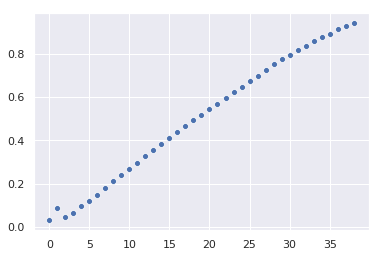

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


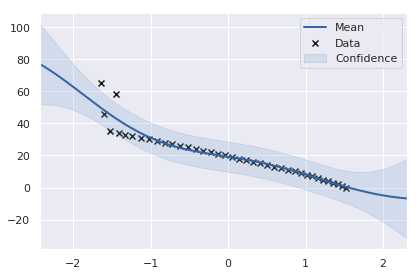

In [4]:
def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(latlon, axis=1)
    return synched_data
    
def train_gps(synched_data, route_n, traj_n, seg_n):
    # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(synched_seg, 
                     ['tau'], 
                     ['lat', 'lon'], 
                     'likelihood-v1', 
                     route_n, 
                     traj_n, 
                     seg_n)
    gp.train(likelihood_model, 5)
    
    prediction_model = gp.build(synched_seg, 
                                ['tau'], 
                                ['time_left'], 
                                'predict-v1', 
                                route_n, 
                                traj_n, 
                                seg_n)
    gp.train(prediction_model, 5)
    return likelihood_model, prediction_model

n_trajs = data.traj.unique()
traj_n = n_trajs[0]
seg_n = n_segs[0]
seg = data[(data.seg == seg_n) & (data.traj == traj_n)]
synch_gp = gp.load_synch(seg_n)
synched_seg = synch_data(synch_gp, seg)
likelihood_model, prediction_model = train_gps(synched_seg, route_n, traj_n, seg_n)


#likelihood_model, prediction_model = train_gp(seg, synch_gps[seg_n], route_n, traj_n, seg_n)
sns.scatterplot(data=synched_seg.tau)
gp.plot(prediction_model)
#mean, _var = gp.predict(model, seg)
#plot_df = pd.DataFrame({'tau': })
#

#for traj_n in n_trajs:
#    traj = data[data.traj == traj_n]
#    for seg_n in n_segs:
#        seg = traj[traj.seg == seg_n]
#        synch_gp = synch_gps[seg_n]
#        likelihood_model, prediction_model = train_gp(seg, synch_gp, route_n, seg_n, traj_n)
#        gp.save(likelihood_model)
#        gp.save(prediction_model)
#        gp.plot(likelihood_model)
#        gp.plot(prediction_model)

Let's plot some of the GPs to see what they look like

In [ ]:
for seg_n in n_segs:
    gp1 = gp.load(data[data.seg == n_segs[0]], 
                  ['lat', 'lon'], 
                  ['progress'], 
                  'likelihood-v1', 
                  route_n, 
                  n_trajs[0], 
                  seg_n)
    gp.plot(gp1)
#gp2 = gp.load(data[data.seg == n_segs[1]], ['lat', 'lon'], ['progress'], 'likelihood-v1', route_n, n_segs[0], n_trajs[0])
#gp3 = gp.load(data[data.seg == n_segs[1]], ['lat', 'lon'], ['progress'], 'likelihood-v1', route_n, n_segs[0], n_trajs[0])
#gp.plot(gp2)
#gp.plot(gp3)

The results look reasonable, even though they are not amazing. It looks fairly likely that each process could have generated respective data.

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

In [ ]:
# We load the parameters of the learned GPs once
learned_params = gp.load_all_params('likelihood-v1')
# together with the test data
test = pd.read_pickle('test.pkl')
# and the arrival times
with open('travel_times.pkl', 'rb') as handle:
    travel_times = pickle.load(handle)

In [ ]:
def predict(learned_params, synch_gps, traj):
    seg_n = traj.iloc[0].seg # assume all data points are from same seg as the first
    synch_gp = synch_gps[seg_n]
    synched_traj = synch_data(synch_gp, traj)
    gps = most_likely_learned_gp(learned_params, synch_gp, synched_traj)
   # arrival_times[gps
   # return trajs
    #learned_trajs = [gp.build(test_traj, )]
    gp.plot(gps[0])
        
    return gps

def most_likely_learned_gp(learned_params, synch_gp, traj):
    mk_model = lambda r, t, s, p: gp.set_params(gp.build(traj, ['tau'], ['lat', 'lon'], 'tmp', r, t, s), p)
    models = [mk_model(*p) for p in learned_params]
    return sorted(models, key=gp.loglik)
    
test_trajs = test[test.seg == seg_n]
n_test_trajs = test_trajs.traj.unique()
predictions = [predict(learned_params, synch_gps, test_trajs[test_trajs.traj == traj_n]) for traj_n in n_test_trajs]
